In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import seaborn as sns


In [3]:
data = pd.read_csv("ACE2_train_data.csv")
data_antibody = pd.read_csv("LY16_train_data.csv")
data.info

<bound method DataFrame.info of         Unnamed: 0               junction_aa  consensus_count  Label  Distance
0           287261  KNAGFNCYNPLETYGFWRTGGVDW                1      1         9
1           467439  KNEQFNCYGPINAYGFQRTGGEDW                1      0        10
2           414422  KNQKFNCYVPLFHYGFWPTVGVGF                1      1         8
3           103144  KNQGFNCYNPLVNYGFYRTNGRSF                1      1         9
4           478954  KNRGFNCYKPLPGYGFQRTDGINW                2      0         9
...            ...                       ...              ...    ...       ...
406881       16530  KNKGFNCYIPIEDYGFQRTSGRSY                2      0         9
406882       48280  KNEGFNCYNPITEYGFWTTSGLDW                2      1        10
406883      420449  KNGKFNCYHPIVRYGFHPTVGRGY                2      1         9
406884      173734  KNGQFNCYIPIAGYGFLPTLGVSY                1      0         9
406885      554432  KNRGFNCYTPIFKYGFFTTWGRNY                1      0        10

[406886 rows x 5 co

In [ ]:
"""
Data preprocessing:

One-hot encoding
Train-test split
"""
# One-hot encoding
def one_hot_encode(sequence, aa_vocab):
    encoding = np.zeros((len(sequence), len(aa_vocab)))
    for i, aa in enumerate(sequence):
        encoding[i, aa_vocab.index(aa)] = 1
    return encoding

aa_vocab = sorted(set(''.join(data['junction_aa'].tolist())))
data['junction_aa_encoded'] = data['junction_aa'].apply(lambda x: one_hot_encode(x, aa_vocab))

# Train-test split
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)
X_train = torch.tensor(np.stack(train_data['junction_aa_encoded'].values), dtype=torch.float32)
y_train = torch.tensor(train_data['Label'].values, dtype=torch.long)

X_val = torch.tensor(np.stack(val_data['junction_aa_encoded'].values), dtype=torch.float32)
y_val = torch.tensor(val_data['Label'].values, dtype=torch.long)


In [5]:
"""
Dataset:
"""
class OneHotDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    

train_dataset = OneHotDataset(X_train, y_train)
val_dataset = OneHotDataset(X_val, y_val)

In [6]:
"""
Data loaders:
"""
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [21]:
"""
Model: OneHot encoding + CNN
"""
class CNNModel2D(nn.Module):
    def __init__(self, num_classes, input_size, num_filters):
        super(CNNModel2D, self).__init__()
        self.conv = nn.Conv2d(1, num_filters, kernel_size=(3, input_size), padding=(1, 0))
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=(2, 1))
        self.fc = nn.Linear(768, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Set up model, loss function, and optimizer
input_size = len(aa_vocab)
num_classes = 1
num_filters = 64

model = CNNModel2D(num_classes, input_size, num_filters)
criterion = F.binary_cross_entropy_with_logits
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [22]:
"""
Additional imports:
"""
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

Epoch 1/10, Loss: 0.2662
Unique values in y_true: [0 1]
Unique values in y_pred: [0 1]
Validation loss: 0.5719, Accuracy: 90.56%, Precision: 0.91, Recall: 0.91, F1-score: 0.91
Epoch 2/10, Loss: 0.2502
Unique values in y_true: [0 1]
Unique values in y_pred: [0 1]
Validation loss: 0.5650, Accuracy: 91.35%, Precision: 0.91, Recall: 0.91, F1-score: 0.91
Epoch 3/10, Loss: 0.2489
Unique values in y_true: [0 1]
Unique values in y_pred: [0 1]
Validation loss: 0.5672, Accuracy: 91.17%, Precision: 0.91, Recall: 0.91, F1-score: 0.91
Epoch 4/10, Loss: 0.2482
Unique values in y_true: [0 1]
Unique values in y_pred: [0 1]
Validation loss: 0.5663, Accuracy: 91.31%, Precision: 0.91, Recall: 0.91, F1-score: 0.91
Epoch 5/10, Loss: 0.2477
Unique values in y_true: [0 1]
Unique values in y_pred: [0 1]
Validation loss: 0.5654, Accuracy: 91.23%, Precision: 0.91, Recall: 0.91, F1-score: 0.91
Epoch 6/10, Loss: 0.2474
Unique values in y_true: [0 1]
Unique values in y_pred: [0 1]
Validation loss: 0.5657, Accuracy

<function matplotlib.pyplot.legend(*args, **kwargs)>

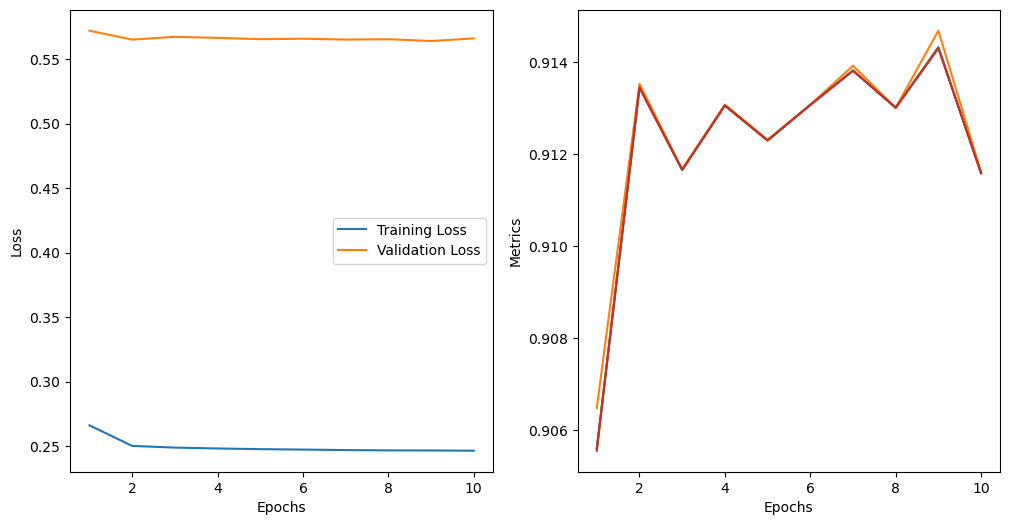

In [24]:
"""
Model training:
"""
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Storing metrics
train_losses = []
val_losses = []
accuracies = []
precisions = []
recalls = []
f1_scores = []


for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.flatten(), y_batch.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_dataset)
    train_losses.append(train_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}')

    # Validation
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X_batch, y_batch in val_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = torch.sigmoid(model(X_batch))
            probs = torch.sigmoid(outputs)
            predicted = (outputs > 0.5).long().flatten()
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            
            total += y_batch.size(0)
            
            loss = criterion(outputs, y_batch.unsqueeze(1).float())
            
            val_loss += loss.item() * X_batch.size(0)
            
    val_loss /= len(val_dataset)
    val_losses.append(val_loss)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    print("Unique values in y_true:", np.unique(y_true))
    print("Unique values in y_pred:", np.unique(y_pred))
    
    # Store metrics
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    print(f'Validation loss: {val_loss:.4f}, Accuracy: {accuracy * 100:.2f}%, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}')
 

# Plotting metrics
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, label='Accuracy')
plt.plot(epochs, precisions, label='Precision')
plt.plot(epochs, recalls, label='Recall')
plt.plot(epochs, f1_scores, label='F1-score')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend



tensor([[ 1.9061, -1.9125],
        [-1.3609,  1.3270],
        [ 1.6332, -1.4236],
        [-2.2106,  2.2035],
        [-1.1135,  1.1490],
        [-0.5648,  0.6799],
        [-1.5008,  1.6274],
        [-1.4327,  1.6548],
        [ 0.1736, -0.2324],
        [-0.1617,  0.1369],
        [-3.4532,  3.6403],
        [ 1.1235, -1.0366],
        [-0.9773,  1.2504],
        [-3.5973,  3.5985],
        [-0.2451,  0.3392],
        [-1.8440,  2.0539],
        [ 2.0940, -1.9796],
        [ 1.1990, -1.0282],
        [ 2.4201, -2.3147],
        [ 3.3025, -3.2117],
        [-2.0950,  2.0967],
        [-2.1020,  2.2469],
        [ 2.1391, -2.0786],
        [-2.5700,  2.5755],
        [ 2.9492, -2.9359],
        [-1.1789,  1.1987],
        [ 3.2555, -3.2212],
        [ 0.8962, -0.8924],
        [-2.9345,  3.0106],
        [ 2.7089, -2.6382],
        [ 1.4687, -1.4003],
        [-1.4226,  1.5782],
        [ 3.7670, -3.7552],
        [-4.3118,  4.3001]])

In [25]:
"""
Model evaluation: OLD CODE OLD CODE OLD CODE
"""
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
import matplotlib.pyplot as plt

model.eval()
true_labels = []
predicted_probs = []

with torch.no_grad():
    for X_batch, y_batch in val_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        predicted_probs_batch = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        true_labels.extend(y_batch.cpu().numpy())
        predicted_probs.extend(predicted_probs_batch)
        

fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
roc_auc = roc_auc_score(true_labels, predicted_probs)

precision, recall, _ = precision_recall_curve(true_labels, predicted_probs)
average_precision = average_precision_score(true_labels, predicted_probs)


# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve (average precision = %0.2f)' % average_precision)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

IndexError: index 1 is out of bounds for dimension 1 with size 1